## DATA 620 Final Project
#### Amazon Software Reviews

Benson Toi, Noah Collin, Ahmed Elsaeyed

Data source:
https://nijianmo.github.io/amazon/index.html

This is a sentiment analyisis of Amazon reviews of software from 1998-2015

In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import random
import nltk
from tqdm import tqdm, trange #for progress bars of computation in Jupyter, see https://www.youtube.com/watch?v=n4E7of9BINo

In [2]:
from transformers import pipeline

C:\Users\Noah\anaconda3\envs\dummty2\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
print("Pandas version: {}".format(pd.__version__))
#print("datetime version: {}".format(datetime.__version__))
print("Seaborn version: {}".format(sns.__version__))

Pandas version: 1.3.5
Seaborn version: 0.11.2


In [4]:
df = pd.read_json('Software.json',  lines=True) #lines equal true because the CSV has \n chars

In [5]:
df.columns

Index(['overall', 'verified', 'reviewTime', 'reviewerID', 'asin', 'style',
       'reviewerName', 'reviewText', 'summary', 'unixReviewTime', 'vote',
       'image'],
      dtype='object')

In [6]:
df.head(3)

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,4,True,"03 11, 2014",A240ORQ2LF9LUI,0077613252,{'Format:': ' Loose Leaf'},Michelle W,The materials arrived early and were in excell...,Material Great,1394496000,NaN,NaN
1,4,True,"02 23, 2014",A1YCCU0YRLS0FE,0077613252,{'Format:': ' Loose Leaf'},Rosalind White Ames,I am really enjoying this book with the worksh...,Health,1393113600,NaN,NaN
2,1,True,"02 17, 2014",A1BJHRQDYVAY2J,0077613252,{'Format:': ' Loose Leaf'},Allan R. Baker,"IF YOU ARE TAKING THIS CLASS DON""T WASTE YOUR ...",ARE YOU KIDING ME?,1392595200,7,NaN


In [7]:
def HumanTime (x):
    return datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S')

HumanTime(df['unixReviewTime'][0])

'2014-03-11 00:00:00'

In [8]:
df['ReviewTime']= tqdm(df.unixReviewTime.apply(HumanTime))


100%|██████████| 459436/459436 [00:00<00:00, 2125481.05it/s]


In [9]:
df['ReviewTime'].head(3)

0    2014-03-11 00:00:00
1    2014-02-23 00:00:00
2    2014-02-17 00:00:00
Name: ReviewTime, dtype: object

In [10]:
df['Year'] = df['ReviewTime'].apply(lambda x: int(re.findall ("\d+", x)[0]))

In [11]:
df['Year'].value_counts().sort_index()

1998        1
1999      125
2000     1326
2001     2833
2002     4144
2003     4681
2004     4685
2005     6724
2006     8486
2007    13962
2008    17735
2009    20000
2010    15185
2011    17061
2012    22894
2013    46663
2014    77348
2015    86324
2016    66786
2017    29350
2018    13123
Name: Year, dtype: int64

In [12]:
df.reviewText.describe()

count     459370
unique    421432
top         good
freq         811
Name: reviewText, dtype: object

In [13]:
df.summary.describe()

count         459380
unique        286888
top       Five Stars
freq           51188
Name: summary, dtype: object

In [14]:
df.overall.value_counts().sort_index()

1    102548
2     31445
3     39395
4     73596
5    212452
Name: overall, dtype: int64

In [15]:
df.overall.describe() #Review Scores

count    459436.000000
mean          3.570175
std           1.626662
min           1.000000
25%           2.000000
50%           4.000000
75%           5.000000
max           5.000000
Name: overall, dtype: float64

In [16]:
df['overall'].median()

4.0

In [17]:
df['style'].describe()

count                            234401
unique                              423
top       {'Platform:': ' PC Download'}
freq                              50647
Name: style, dtype: object

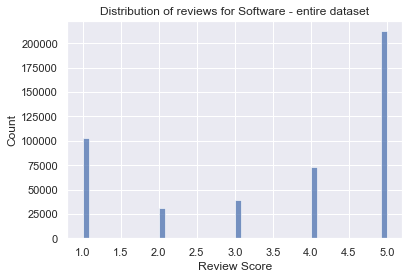

In [18]:
sns.set(style="darkgrid")
sns.histplot(df['overall']).set(title = "Distribution of reviews for Software - entire dataset",
                                        xlabel = 'Review Score')
plt.show()

Mostly five-star reviews.

In [19]:
oneStarReviews = df[df['overall']==1]
oneStarReviews.shape

(102548, 14)

In [20]:
twoStarReviews = df[df['overall']==2]
threeStarReviews = df[df['overall']==3]
fourStarReviews = df[df['overall']==4]
fiveStarReviews = df[df['overall']==5]

In [21]:
random.seed(6174)
#Kaprekar’s constant

In [24]:
randomSelection = random.choices(range(len(df)), k=1000) 
# we're going to work with 1000 reviews to lessen run times
randomSelection

[307112,
 347418,
 263215,
 160299,
 319893,
 15604,
 302264,
 429945,
 282644,
 313262,
 187106,
 327304,
 458447,
 216,
 253435,
 331357,
 133904,
 94763,
 79153,
 179010,
 114740,
 234293,
 422968,
 36238,
 344910,
 152447,
 225264,
 415777,
 229686,
 122034,
 318454,
 30193,
 361921,
 27743,
 126082,
 36290,
 409860,
 379886,
 437757,
 380590,
 48811,
 307450,
 263979,
 137414,
 144350,
 171441,
 169728,
 311716,
 332873,
 376193,
 122652,
 38174,
 391451,
 425500,
 416872,
 426600,
 423546,
 16672,
 189090,
 206898,
 186141,
 22882,
 265936,
 150969,
 458949,
 58514,
 31400,
 12048,
 342541,
 244798,
 300593,
 335451,
 383737,
 76546,
 430389,
 79804,
 431440,
 366999,
 109291,
 339239,
 201881,
 385790,
 135139,
 217225,
 225669,
 198798,
 389248,
 254191,
 262193,
 76224,
 110522,
 431632,
 286072,
 77019,
 175790,
 210496,
 440248,
 128698,
 210161,
 346301,
 387866,
 421721,
 251265,
 93432,
 263648,
 73282,
 104891,
 282339,
 152415,
 169836,
 229644,
 107930,
 399637,
 39051

In [28]:
df1000 = df.loc[randomSelection,]
df1000.head(3)

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image,ReviewTime,Year
307112,5,True,"08 29, 2017",A38C6X614AVSFF,B00UB76290,{'Platform:': ' PC Download'},Richard842,Great app for Reading.,Great App,1503964800,NaN,NaN,2017-08-29 00:00:00,2017
347418,5,True,"03 28, 2016",A212KOWT2OTHN1,B01617VQJ4,{'Platform:': ' PC/MacDisc'},Allyson,Worked as expected.,Five Stars,1459123200,NaN,NaN,2016-03-28 00:00:00,2016
263215,1,True,"09 18, 2015",ASOWD67MEFZFN,B00MEO1G08,{'Platform:': ' PC Download'},Michael,The program does not complete the installation...,Won't Work with Windows 10,1442534400,NaN,NaN,2015-09-18 00:00:00,2015


In [ ]:
sns.set(style="darkgrid")
sns.histplot(df1000['overall']).set(title = "Distribution of reviews for Software - 1000 random entries",
                                        xlabel = 'Review Score')
plt.show()


In [30]:
df25 = df.loc[randomSelection[:25]]
df25.head(2)

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image,ReviewTime,Year
307112,5,True,"08 29, 2017",A38C6X614AVSFF,B00UB76290,{'Platform:': ' PC Download'},Richard842,Great app for Reading.,Great App,1503964800,NaN,NaN,2017-08-29 00:00:00,2017
347418,5,True,"03 28, 2016",A212KOWT2OTHN1,B01617VQJ4,{'Platform:': ' PC/MacDisc'},Allyson,Worked as expected.,Five Stars,1459123200,NaN,NaN,2016-03-28 00:00:00,2016


In [31]:
vocab= []
for c, r in df1000.iterrows():
    tokens =( nltk.word_tokenize(r['reviewText']) )
    for token in tokens:
        vocab.append(token)


In [32]:
vocabulary = set(vocab) # to assure no duplicates.  As of now, we haven't handled capitalization

In [37]:
classifier = pipeline("sentiment-analysis")
currentClassifierType = "sentiment-analysis"
#This cell will download models the first time it's run.  
#These are large so don't use a metered connection if possible.
#default model used, link here:
#https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


In [38]:
def performDefaultSetntimentAnalysis(x):
    if(currentClassifierType != "sentiment-analysis"):
        print("You're using the wrong classifier!  Run the notebook in order.")
        return None
    try:
        return classifier(x)
    except:
        return"UNKNOWN"

In [41]:

df25['distilbert-base-uncased sentiment-analysis'] = tqdm(
    df25['reviewText'].apply(performDefaultSetntimentAnalysis)
,total = len(df25))
#This cell will take several minutes to run

100%|██████████| 25/25 [00:00<?, ?it/s]


In [42]:
df25.head(3)

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image,ReviewTime,Year,distilbert-base-uncased sentiment-analysis
307112,5,True,"08 29, 2017",A38C6X614AVSFF,B00UB76290,{'Platform:': ' PC Download'},Richard842,Great app for Reading.,Great App,1503964800,NaN,NaN,2017-08-29 00:00:00,2017,"[{'label': 'POSITIVE', 'score': 0.999747216701..."
347418,5,True,"03 28, 2016",A212KOWT2OTHN1,B01617VQJ4,{'Platform:': ' PC/MacDisc'},Allyson,Worked as expected.,Five Stars,1459123200,NaN,NaN,2016-03-28 00:00:00,2016,"[{'label': 'POSITIVE', 'score': 0.990992963314..."
263215,1,True,"09 18, 2015",ASOWD67MEFZFN,B00MEO1G08,{'Platform:': ' PC Download'},Michael,The program does not complete the installation...,Won't Work with Windows 10,1442534400,NaN,NaN,2015-09-18 00:00:00,2015,"[{'label': 'NEGATIVE', 'score': 0.999763906002..."


In [43]:
classifier = pipeline("zero-shot-classification")

currentClassifierType = "zero-shot-classification"
type(classifier)
#This cell involves a 1.5+ GB download

No model was supplied, defaulted to facebook/bart-large-mnli (https://huggingface.co/facebook/bart-large-mnli)


transformers.pipelines.zero_shot_classification.ZeroShotClassificationPipeline

In [44]:
#DELETE, testing, screwing around
classifier(
    "I just ate great Spanish food with my foes.",
    candidate_labels=["cuisine", "friendship","nihilism"],
)

{'sequence': 'I just ate great Spanish food with my foes.',
 'labels': ['cuisine', 'friendship', 'nihilism'],
 'scores': [0.9875637888908386, 0.006701105274260044, 0.005735073704272509]}

In [45]:
def performZeroShotAnalysis(x, labs = ['endorsement','disapproval']):
    if (currentClassifierType != "zero-shot-classification"):
        print("You aren't using the right classifer now.  Rerun the cell with the ZeroShot.")
        return None
    try:
        return classifier (x, candidate_labels = labs)
    except:
        return "UNKNOWN"

In [65]:
performZeroShotAnalysis('I wish I hadn\'t bought this product.')
#So we can use this pipeline to to classify reviews 

{'sequence': "I wish I hadn't bought this product.",
 'labels': ['disapproval', 'endorsement'],
 'scores': [0.9734046459197998, 0.02659538947045803]}

In [46]:
df25['zero shot facebook/bart-large-mnli'] =  tqdm(df25['reviewText'].apply(performZeroShotAnalysis))

100%|██████████| 25/25 [00:00<?, ?it/s]


In [47]:
df25['zero shot facebook/bart-large-mnli'].values[0:3]
#notice that the labels, "endorsement and dissaproval" change order.  TODO

array([{'sequence': 'Great app for Reading.', 'labels': ['endorsement', 'disapproval'], 'scores': [0.9891048669815063, 0.01089513674378395]},
       {'sequence': 'Worked as expected.', 'labels': ['endorsement', 'disapproval'], 'scores': [0.9563242793083191, 0.043675731867551804]},
       {'sequence': 'The program does not complete the installation.  I tried several times.  Running MS Windows 10.  I ran compatibility check and found it will not work.  Disappointing.', 'labels': ['disapproval', 'endorsement'], 'scores': [0.936623215675354, 0.06337673217058182]}],
      dtype=object)

In [68]:
#This function will always get the Endorsment rating first, then the disapproval rating second.
#The order can sometimes be given in an unexpected way.
#
def getEndorsementThenDissaproval(x):
    endorsementScore = 0
    disapprovalScore = 0
    try:
        if(x['labels'][0]=='endorsement'):
            endorsementScore = x['scores'][0]
            disapprovalScore = x['scores'][1]
            return [endorsementScore, disapprovalScore]
        elif (x['labels'][0]=='disapproval'):
            endorsementScore = x['scores'][1] #flip-flopped
            disapprovalScore = x['scores'][0] 
            return [endorsementScore, disapprovalScore]
        else:
            print('something wrong here')
            return [-2,-2]
    except:
        return [-1,-1]

In [67]:
getEndorsementThenDissaproval ( df25['zero shot facebook/bart-large-mnli'].values[22] )

[0.1789337396621704, 0.8210662603378296]

In [66]:
df25['zero shot facebook/bart-large-mnli'].values[22]

{'sequence': "I've been using Foxit PhantomPDF (both the Standard and Business editions) for several years.  Like all software, there are bugs and annoyances, but most haven't been too terrible.  That was true until version 7.3 came along.  Foxit made major changes to the user interface (which is now exclusively the Ribbon Bar mode, regardless of which Windows OS version is being used).  The interface is extraordinarily clumsy and there are many, many bugs in the product.  Even simple things like selecting text to be copied to the clipboard is a hit or miss proposition; more often than not the text which you've highlighted for selection gets lopped off by the time it reaches the clipboard.  PDF editing and forms processing is so broken it's nearly useless.  I've had quite a bit of interaction with the Foxit support organization; they are cordial but ineffective at problem resolution and acknowledging true defects in the product.  Perhaps when Release 8 is delivered some of these major 

In [106]:
endorsmentsList = []
disapprovalsList =[]
for i in df25['zero shot facebook/bart-large-mnli'].index:
    endorsmentsList.append(
        getEndorsementThenDissaproval(
        df25['zero shot facebook/bart-large-mnli'][i]
                          )[0]
    )
    disapprovalsList.append(
        getEndorsementThenDissaproval(
        df25['zero shot facebook/bart-large-mnli'][i]
                          )[1]
    )


#for i in range(len(df25)):
#    print(df25['zero shot facebook/bart-large-mnli'][i])

In [115]:
df25['endorsment per zero shot facebook/bart-large-mnli']= endorsmentsList
df25['disapproval per zero shot facebook/bart-large-mnli']= disapprovalsList

In [116]:
df25.head(3)

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image,ReviewTime,Year,distilbert-base-uncased sentiment-analysis,zero shot facebook/bart-large-mnli,a,b,endorsment per zero shot facebook/bart-large-mnli,disapproval per zero shot facebook/bart-large-mnli
307112,5,True,"08 29, 2017",A38C6X614AVSFF,B00UB76290,{'Platform:': ' PC Download'},Richard842,Great app for Reading.,Great App,1503964800,NaN,NaN,2017-08-29 00:00:00,2017,"[{'label': 'POSITIVE', 'score': 0.999747216701...","{'sequence': 'Great app for Reading.', 'labels...",1,2,0.989105,0.010895
347418,5,True,"03 28, 2016",A212KOWT2OTHN1,B01617VQJ4,{'Platform:': ' PC/MacDisc'},Allyson,Worked as expected.,Five Stars,1459123200,NaN,NaN,2016-03-28 00:00:00,2016,"[{'label': 'POSITIVE', 'score': 0.990992963314...","{'sequence': 'Worked as expected.', 'labels': ...",1,2,0.956324,0.043676
263215,1,True,"09 18, 2015",ASOWD67MEFZFN,B00MEO1G08,{'Platform:': ' PC Download'},Michael,The program does not complete the installation...,Won't Work with Windows 10,1442534400,NaN,NaN,2015-09-18 00:00:00,2015,"[{'label': 'NEGATIVE', 'score': 0.999763906002...",{'sequence': 'The program does not complete th...,1,2,0.063377,0.936623


25